## Chest CT Registration

Authors: **Muhammad Zain Amin**, **Mohammad Imran Hossain**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

In [1]:
# Import libraries
import os
import re
import time
import pandas as pd
import SimpleITK as sitk
import tempfile
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import shutil
from scipy import ndimage
from collections import Counter
from skimage import measure
from skimage import exposure
from pathlib import Path
from tabulate import tabulate

### Folders creation for storing the elastix outputs

In [2]:
# CT cases ids
list_id = [1, 2, 3, 4]

for val_i in list_id:
    id = val_i
    data_directory = "D:/MIRA_Final_Project/Dataset/results_affine_bspline_preprocessed_v3/copd{}/".format(val_i)
    
    # Providing the path to the output directory
    elastix_directory = data_directory + "elastix_out"

    # Creating the Output Directory for the Registrations
    try:
        os.makedirs(elastix_directory)
        os.makedirs(os.path.join(elastix_directory, "registered_moving"))
        os.makedirs(os.path.join(elastix_directory, "registered_landmarks"))
        print(f"Directories created for ID {val_i}")
    except OSError as e:
        print(f"Error: {e}")

Directories created for ID 1
Directories created for ID 2
Directories created for ID 3
Directories created for ID 4


### Convert the raw image files to the nifti format

In [3]:
def get_image_info(metadata_file):
    metadata_df = pd.read_csv(metadata_file)
    metadata_dict = {}
    image_names = metadata_df["Label"].values.tolist()

    image_dims = [
        (i, j, k)
        for i, j, k in zip(
            metadata_df["image_dims0"],
            metadata_df["image_dims1"],
            metadata_df["image_dims2"],
        )
    ]
    vspacing = [
        (i, j, k)
        for i, j, k in zip(
            metadata_df["vspacing0"],
            metadata_df["vspacing1"],
            metadata_df["vspacing2"],
        )
    ]
    displacement_mean = metadata_df["displacement_mean"].values.tolist()
    displacement_std = metadata_df["displacement_std"].values.tolist()

    for i, (dim, vspacing, dis_mean, dis_std) in enumerate(
        zip(image_dims, vspacing, displacement_mean, displacement_std)
    ):
        metadata_dict[image_names[i]] = [dim, vspacing, dis_mean, dis_std]
    return metadata_dict


def read_raw(
    binary_file_name,
    image_size,
    sitk_pixel_type,
    image_spacing=None,
    image_origin=None,
    big_endian=False,
):
    
    pixel_dict = {
        sitk.sitkUInt8: "MET_UCHAR",
        sitk.sitkInt8: "MET_CHAR",
        sitk.sitkUInt16: "MET_USHORT",
        sitk.sitkInt16: "MET_SHORT",
        sitk.sitkUInt32: "MET_UINT",
        sitk.sitkInt32: "MET_INT",
        sitk.sitkUInt64: "MET_ULONG_LONG",
        sitk.sitkInt64: "MET_LONG_LONG",
        sitk.sitkFloat32: "MET_FLOAT",
        sitk.sitkFloat64: "MET_DOUBLE",
    }
    direction_cosine = [
        "1 0 0 1",
        "1 0 0 0 1 0 0 0 -1",
        "1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1",
    ]
    dim = len(image_size)
    header = [
        "ObjectType = Image\n".encode(),
        (f"NDims = {dim}\n").encode(),
        ("DimSize = " + " ".join([str(v) for v in image_size]) + "\n").encode(),
        (
            "ElementSpacing = "
            + (
                " ".join([str(v) for v in image_spacing])
                if image_spacing
                else " ".join(["1"] * dim)
            )
            + "\n"
        ).encode(),
        (
            "Offset = "
            + (
                " ".join([str(v) for v in image_origin])
                if image_origin
                else " ".join(["0"] * dim) + "\n"
            )
        ).encode(),
        ("TransformMatrix = " + direction_cosine[dim - 2] + "\n").encode(),
        ("ElementType = " + pixel_dict[sitk_pixel_type] + "\n").encode(),
        "BinaryData = True\n".encode(),
        ("BinaryDataByteOrderMSB = " + str(big_endian) + "\n").encode(),
        ("ElementDataFile = " + os.path.abspath(binary_file_name) + "\n").encode(),
    ]
    fp = tempfile.NamedTemporaryFile(suffix=".mhd", delete=False)
    fp.writelines(header)
    fp.close()
    img = sitk.ReadImage(fp.name)
    os.remove(fp.name)
    return img

In [4]:
def save_rawtositk(dataset_option="results_affine_bspline_preprocessed_v3", metadata_file="D:/MIRA_Final_Project/dataset/copd_metadata.csv"):
    datadir = Path("D:/MIRA_Final_Project/dataset") / Path(dataset_option)
    metadata_dict = get_image_info(metadata_file)
    raw_images_names = [i for i in datadir.rglob("*.img") if "copd" in str(i)]
    
    for raw_name in raw_images_names:
        case = raw_name.parent.stem
        out_filename = str(raw_name).replace(".img", ".nii.gz")
        
        start_time = time.time()  # Record start time
        
        image = read_raw(
            binary_file_name=raw_name,
            image_size=metadata_dict[case][0],
            sitk_pixel_type=sitk.sitkInt16,
            big_endian=False,
            image_spacing=metadata_dict[case][1],
        )
        
        sitk.WriteImage(image, out_filename)
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time  # Calculate elapsed time        
        raw_name_short = Path(raw_name).name  # Extract only the file name
        print(f"Image {raw_name_short} saved. Time taken: {elapsed_time:.2f} seconds.")


# Run the function with arguments
save_rawtositk(dataset_option="results_affine_bspline_preprocessed_v3", metadata_file="D:/MIRA_Final_Project/dataset/copd_metadata.csv")

Image copd1_eBHCT.img saved. Time taken: 9.11 seconds.
Image copd1_iBHCT.img saved. Time taken: 9.56 seconds.
Image copd2_eBHCT.img saved. Time taken: 6.75 seconds.
Image copd2_iBHCT.img saved. Time taken: 7.12 seconds.
Image copd3_eBHCT.img saved. Time taken: 8.33 seconds.
Image copd3_iBHCT.img saved. Time taken: 9.52 seconds.
Image copd4_eBHCT.img saved. Time taken: 8.36 seconds.
Image copd4_iBHCT.img saved. Time taken: 9.85 seconds.


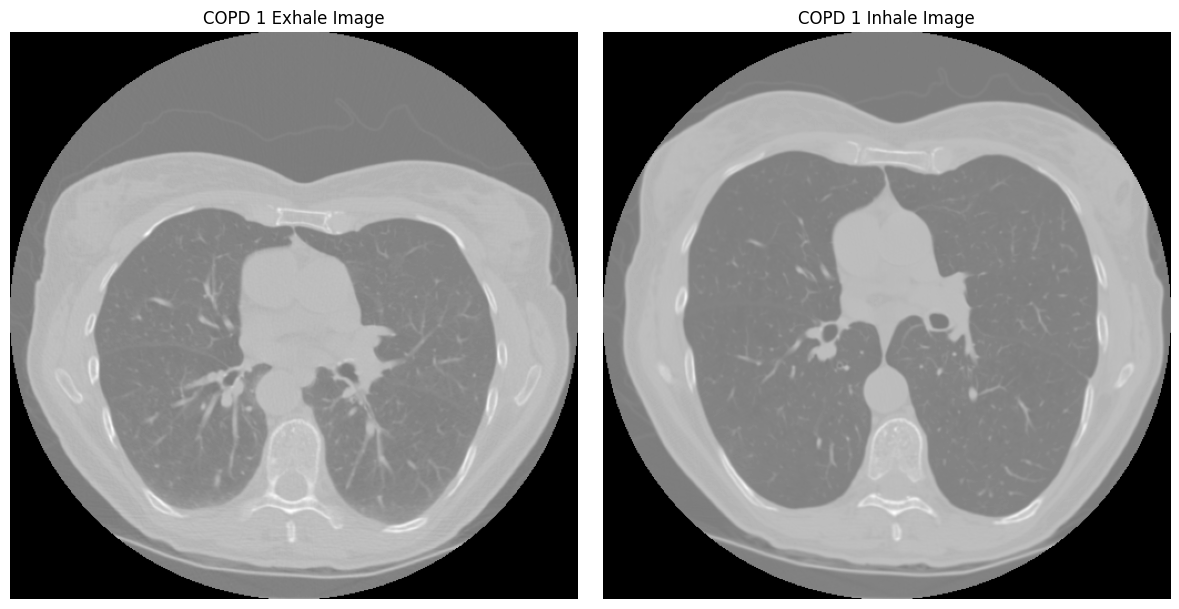

In [5]:
# Load the exhale image
exhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_eBHCT.nii.gz")
img_data_1 = exhale_copd1.get_fdata()

# Load the inhale image
inhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_iBHCT.nii.gz")
img_data_2 = inhale_copd1.get_fdata()

img_data_1 = np.rot90(img_data_1, k=-1)
img_data_2 = np.rot90(img_data_2, k=-1)

# Plotting the images side by side
plt.figure(figsize=(12, 6))
z_slice_1 = img_data_1.shape[2] // 2
z_slice_2 = img_data_2.shape[2] // 2

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img_data_1[:, :, z_slice_1], cmap='gray')
plt.axis('off')
plt.title('COPD 1 Exhale Image')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img_data_2[:, :, z_slice_2], cmap='gray')
plt.axis('off') 
plt.title('COPD 1 Inhale Image')

plt.tight_layout() 
plt.show()

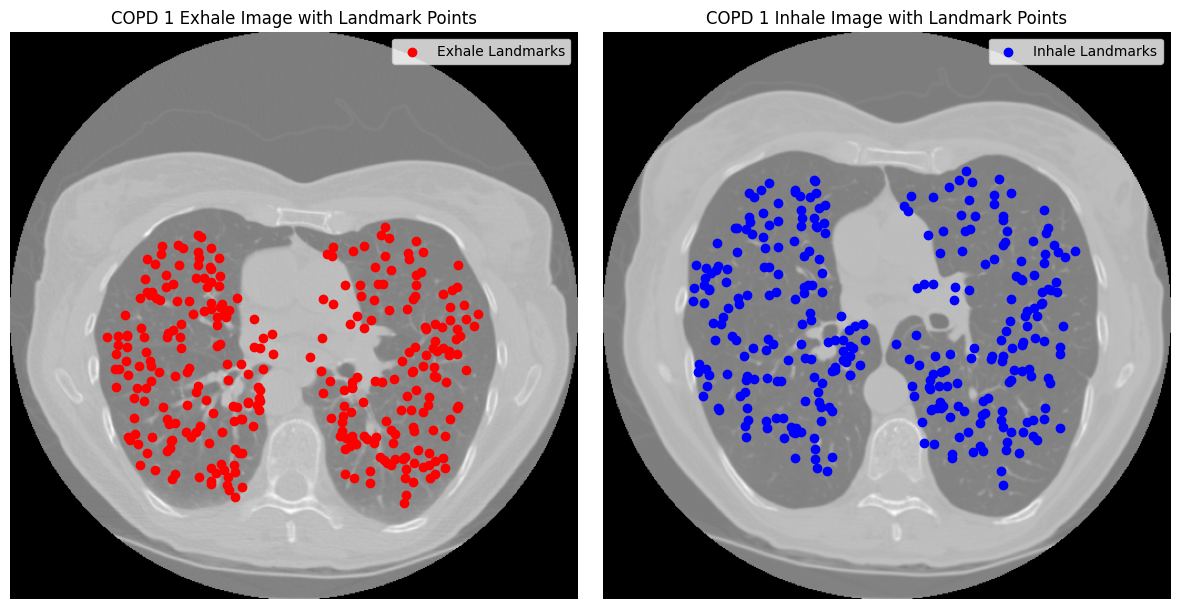

In [6]:
# Load the exhale and inhale images
exhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_eBHCT.nii.gz")
img_data_1 = exhale_copd1.get_fdata()

inhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_iBHCT.nii.gz")
img_data_2 = inhale_copd1.get_fdata()

img_data_1_rotated = np.rot90(img_data_1, k=-1)
img_data_2_rotated = np.rot90(img_data_2, k=-1)

# Load landmark points for exhale and inhale images from text files
def read_landmarks(file_path):
    landmarks = np.loadtxt(file_path)
    return landmarks

landmarks_exhale_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_300_eBH_xyz_r1.txt"  
landmarks_inhale_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_300_iBH_xyz_r1.txt"

landmarks_exhale = read_landmarks(landmarks_exhale_path)
landmarks_inhale = read_landmarks(landmarks_inhale_path)

# Plotting the images side by side with landmarks
plt.figure(figsize=(12, 6))
z_slice_1 = img_data_1_rotated.shape[2] // 2
z_slice_2 = img_data_2_rotated.shape[2] // 2

# Plot the first image with exhale landmarks
plt.subplot(1, 2, 1)
plt.imshow(img_data_1_rotated[:, :, z_slice_1], cmap='gray')
plt.scatter(landmarks_exhale[:, 0], landmarks_exhale[:, 1], c='red', marker='o', label='Exhale Landmarks')
plt.axis('off')
plt.title('COPD 1 Exhale Image with Landmark Points')
plt.legend()

# Plot the second image with inhale landmarks
plt.subplot(1, 2, 2)
plt.imshow(img_data_2_rotated[:, :, z_slice_2], cmap='gray')
plt.scatter(landmarks_inhale[:, 0], landmarks_inhale[:, 1], c='blue', marker='o', label='Inhale Landmarks')
plt.axis('off') 
plt.title('COPD 1 Inhale Image with Landmark Points')
plt.legend()

plt.tight_layout() 
plt.show()

### Preprocessing and Segmentation

In [7]:
def select_largest_components(labeled, x_mid, y_mid, z_band1, z_band2, x_band1, x_band2):
    labels_region1 = labeled[x_mid - x_band2: x_mid - x_band1, y_mid, z_band1: z_band2]
    labels_region2 = labeled[x_mid + x_band1: x_mid + x_band2, y_mid, z_band1: z_band2]

    # Flatten and count labels in each region
    labels_counts1 = Counter(labels_region1.flatten())
    labels_counts2 = Counter(labels_region2.flatten())

    # Remove background label (0) from counts
    del labels_counts1[0]
    del labels_counts2[0]

    # Get the most common label in each region
    largest_label1 = max(labels_counts1, key=labels_counts1.get)
    largest_label2 = max(labels_counts2, key=labels_counts2.get)

    return largest_label1, largest_label2

def morphological_segment(image_path):
    # Load Lung Image
    image = nib.load(image_path)
    image_data = image.get_fdata()

    # Intensity Thresholding & Morphological Operations
    temp = np.zeros(image_data.shape)
    temp[image_data > 0] = 1
    temp[image_data > 800] = 0

    str_el1 = ndimage.generate_binary_structure(3, 1)
    str_el2 = ndimage.iterate_structure(str_el1, 2)
    temp = ndimage.binary_closing(temp, structure=str_el1, iterations=1)
    temp = ndimage.binary_opening(temp, structure=str_el2, iterations=1)

    # The Lung View Estimation
    a, b, c = image_data.shape
    
    # Selecting our cross-section of Connected Components 
    x_val = int(a / 2)
    y_val = int(b / 2)
    x_band1 = int(a / 2 * 0.4)
    x_band2 = int(a / 2 * 0.75)
    z_band1 = int(c * 0.5)
    z_band2 = int(c * 0.75)

    # Selecting the Largest Connected Components in the Lung Volume
    labeled = measure.label(temp)
    label1, label2 = select_largest_components(labeled, x_val, y_val, z_band1, z_band2, x_band1, x_band2)

    # Create a mask with original intensities for lung regions
    segmented_lungs = np.zeros_like(image_data)
    lung_mask = (labeled == label1) | (labeled == label2)
    segmented_lungs[lung_mask] = image_data[lung_mask]

    # Normalize the segmented lung regions to range between 0 and 1
    segmented_lungs = (segmented_lungs - np.min(segmented_lungs)) / (np.max(segmented_lungs) - np.min(segmented_lungs))

    # Applying CLAHE normalization to the segmented lung regions slice-wise
    for i in range(segmented_lungs.shape[2]):
        segmented_lungs[:, :, i] = exposure.equalize_adapthist(segmented_lungs[:, :, i], clip_limit=0.05)

    # Scale back to the original range (0 to 1) for saving as Nifti format
    segmented_lungs = segmented_lungs * (np.max(image_data) - np.min(image_data)) + np.min(image_data)

    segmented_lung = nib.Nifti1Image(segmented_lungs, image.affine, image.header)
    return segmented_lung

In [8]:
# The number of the COPD Patients in the provided dataset 
list_id = [1, 2, 3, 4]

for val_i in list_id:

    start_time = time.time()   # Record start time
    id = val_i
    data_directory = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/".format(val_i, val_i)

    # Providing the Image Directory for Segmentation
    exhale_path = data_directory + 'copd' + str(id) + '_eBHCT.nii.gz'
    inhale_path = data_directory + 'copd' + str(id) + '_iBHCT.nii.gz'
 
    # Obtaining the Segmented Lung Volumes for Exhale Images
    exhale_seg = morphological_segment(exhale_path)
    segmented_exhale_path = "{}seg_copd{}_eBHCT.nii.gz".format(data_directory, id)
    nib.save(exhale_seg, segmented_exhale_path)

    # Obtaining the Segmented Lung Volumes for Inhale Images
    inhale_seg = morphological_segment(inhale_path)
    segmented_inhale_path = "{}seg_copd{}_iBHCT.nii.gz".format(data_directory, id)
    nib.save(inhale_seg, segmented_inhale_path)

    end_time = time.time()     # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Copd{val_i} Preprocessing finished. Time taken: {elapsed_time:.2f} seconds.")

Copd1 Preprocessing finished. Time taken: 42.84 seconds.
Copd2 Preprocessing finished. Time taken: 35.55 seconds.
Copd3 Preprocessing finished. Time taken: 42.93 seconds.
Copd4 Preprocessing finished. Time taken: 43.05 seconds.


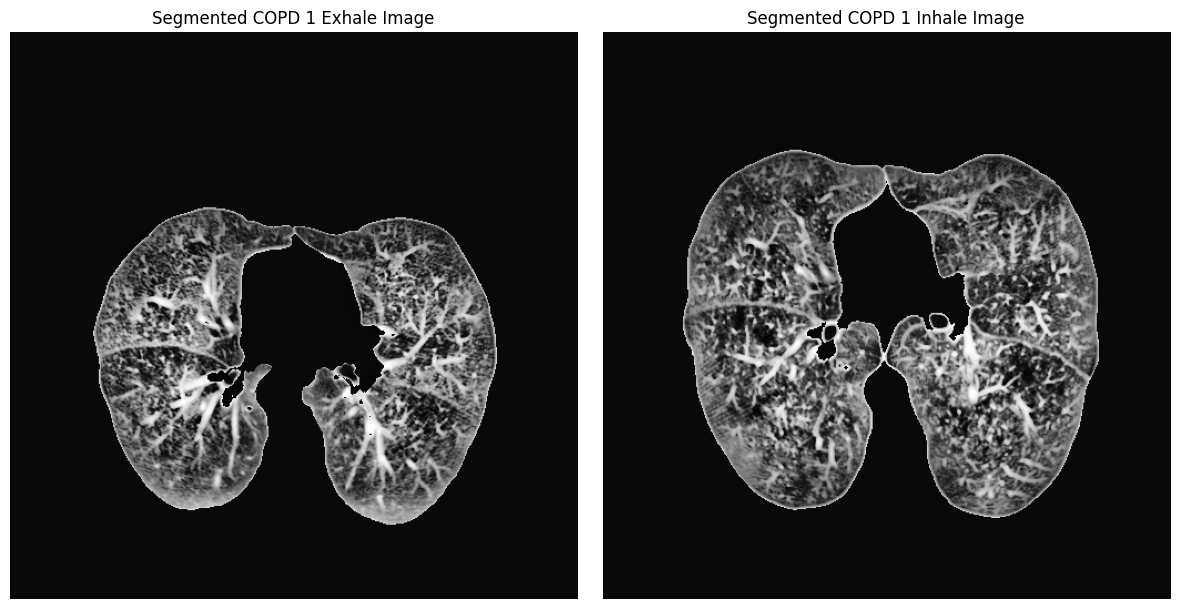

In [9]:
# Load the segmented exhale image
seg_exhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_eBHCT.nii.gz")
img_data_1 = seg_exhale_copd1.get_fdata()

# Load the segmented inhale image
seg_inhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_iBHCT.nii.gz")
img_data_2 = seg_inhale_copd1.get_fdata()

img_data_1 = np.rot90(img_data_1, k=-1)
img_data_2 = np.rot90(img_data_2, k=-1)

# Plotting the images side by side
plt.figure(figsize=(12, 6))
z_slice_1 = img_data_1.shape[2] // 2
z_slice_2 = img_data_2.shape[2] // 2

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img_data_1[:, :, z_slice_1], cmap='gray')
plt.axis('off')
plt.title('Segmented COPD 1 Exhale Image')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img_data_2[:, :, z_slice_2], cmap='gray')
plt.axis('off') 
plt.title('Segmented COPD 1 Inhale Image')

plt.tight_layout() 
plt.show()

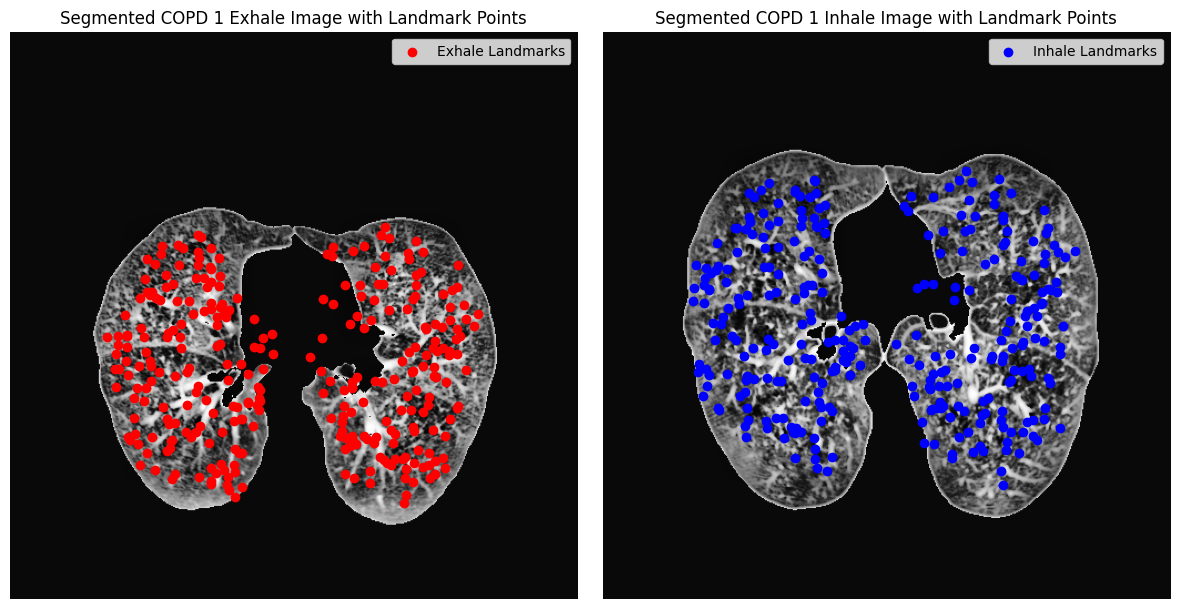

In [10]:
# Load the exhale and inhale images
seg_exhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_eBHCT.nii.gz")
img_data_1 = seg_exhale_copd1.get_fdata()

seg_inhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_iBHCT.nii.gz")
img_data_2 = seg_inhale_copd1.get_fdata()

img_data_1_rotated = np.rot90(img_data_1, k=-1)
img_data_2_rotated = np.rot90(img_data_2, k=-1)

# Load landmark points for exhale and inhale images from text files
def read_landmarks(file_path):
    landmarks = np.loadtxt(file_path)
    return landmarks

landmarks_exhale_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_300_eBH_xyz_r1.txt"  
landmarks_inhale_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_300_iBH_xyz_r1.txt"

landmarks_exhale = read_landmarks(landmarks_exhale_path)
landmarks_inhale = read_landmarks(landmarks_inhale_path)

# Plotting the images side by side with landmarks
plt.figure(figsize=(12, 6))
z_slice_1 = img_data_1_rotated.shape[2] // 2
z_slice_2 = img_data_2_rotated.shape[2] // 2

# Plot the first image with exhale landmarks
plt.subplot(1, 2, 1)
plt.imshow(img_data_1_rotated[:, :, z_slice_1], cmap='gray')
plt.scatter(landmarks_exhale[:, 0], landmarks_exhale[:, 1], c='red', marker='o', label='Exhale Landmarks')
plt.axis('off')
plt.title('Segmented COPD 1 Exhale Image with Landmark Points')
plt.legend()

# Plot the second image with inhale landmarks
plt.subplot(1, 2, 2)
plt.imshow(img_data_2_rotated[:, :, z_slice_2], cmap='gray')
plt.scatter(landmarks_inhale[:, 0], landmarks_inhale[:, 1], c='blue', marker='o', label='Inhale Landmarks')
plt.axis('off') 
plt.title('Segmented COPD 1 Inhale Image with Landmark Points')
plt.legend()

plt.tight_layout() 
plt.show()

### Perform Elastix

In [11]:
# Define the base command to run elastix
elastix_base_command = "elastix -f D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/seg_copd{}_iBHCT.nii.gz -m D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/seg_copd{}_eBHCT.nii.gz -p D:/MIRA_Final_Project/Parameters/affine.txt -p D:/MIRA_Final_Project/Parameters/bspline.txt -out D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/elastix_out"

# Loop through folders 1 to 4 and execute the commands
for i in range(1, 5):
    command = elastix_base_command.format(i, i, i, i, i, i, i)
    start_time = time.time()   # Record start time
    subprocess.run(command, shell=True)
    end_time = time.time()     # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Copd{i} registration executed. Time taken: {elapsed_time:.2f} seconds.")

Copd1 registration executed. Time taken: 584.10 seconds.
Copd2 registration executed. Time taken: 564.08 seconds.
Copd3 registration executed. Time taken: 669.96 seconds.
Copd4 registration executed. Time taken: 496.63 seconds.


### Modify Landmark Files

In [12]:
list_id = [1, 2, 3, 4]

for val_i in list_id:
    # For eBH_xyz files
    eBH_r1_file = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/copd{}_300_eBH_xyz_r1.txt".format(val_i, val_i, val_i)
    eBH_r2_file = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/copd{}_300_eBH_xyz_r2.txt".format(val_i, val_i, val_i)

    # Appending '300' to eBH_r2_file
    with open(eBH_r2_file, 'a') as eBH_secondfile:
        eBH_secondfile.write("300\n")

    # Copying content from eBH_r1_file to eBH_r2_file
    with open(eBH_r1_file, 'r') as eBH_firstfile, open(eBH_r2_file, 'a') as eBH_secondfile:
        for line in eBH_firstfile:
            eBH_secondfile.write(line)

    # For iBH_xyz files
    iBH_r1_file = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/copd{}_300_iBH_xyz_r1.txt".format(val_i, val_i, val_i)
    iBH_r2_file = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/copd{}_300_iBH_xyz_r2.txt".format(val_i, val_i, val_i)

    # Appending '300' to iBH_r2_file
    with open(iBH_r2_file, 'a') as iBH_secondfile:
        iBH_secondfile.write("300\n")

    # Copying content from iBH_r1_file to iBH_r2_file
    with open(iBH_r1_file, 'r') as iBH_firstfile, open(iBH_r2_file, 'a') as iBH_secondfile:
        for line in iBH_firstfile:
            iBH_secondfile.write(line)

### Perform Transformix

In [13]:
# Define the commands
base_command_moving = "transformix -in D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/seg_copd{}_eBHCT.nii.gz -out D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/elastix_out/registered_moving -tp D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/elastix_out/TransformParameters.1.txt"
base_command_landmarks = "transformix -def D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/copd{}_300_iBH_xyz_r2.txt -out D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/elastix_out/registered_landmarks -tp D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/elastix_out/TransformParameters.1.txt"

for i in range(1, 5):
    start_time = time.time()   # Record start time
    command_moving = base_command_moving.format(i, i, i, i, i)
    command_landmarks = base_command_landmarks.format(i, i, i, i, i)
    
    subprocess.run(command_moving, shell=True)
    subprocess.run(command_landmarks, shell=True)

    end_time = time.time()     # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Copd{i} transformix executed. Time taken: {elapsed_time:.2f} seconds.")

Copd1 transformix executed. Time taken: 27.59 seconds.
Copd2 transformix executed. Time taken: 26.11 seconds.
Copd3 transformix executed. Time taken: 32.13 seconds.
Copd4 transformix executed. Time taken: 33.55 seconds.


### Move the Registered Image Files to the Main Directory

In [14]:
list_id = [1, 2, 3, 4]

for val_i in list_id:
 
    id = val_i
    data_directory = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/".format(val_i, val_i)
    
    # Directing the Path to our Registered Image
    result_file = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/".format(val_i) + "elastix_out/registered_moving/result.nii.gz"
    move_to = data_directory + "reg_copd{}_BHCT.nii.gz".format(val_i)
    
    shutil.move(result_file, move_to)

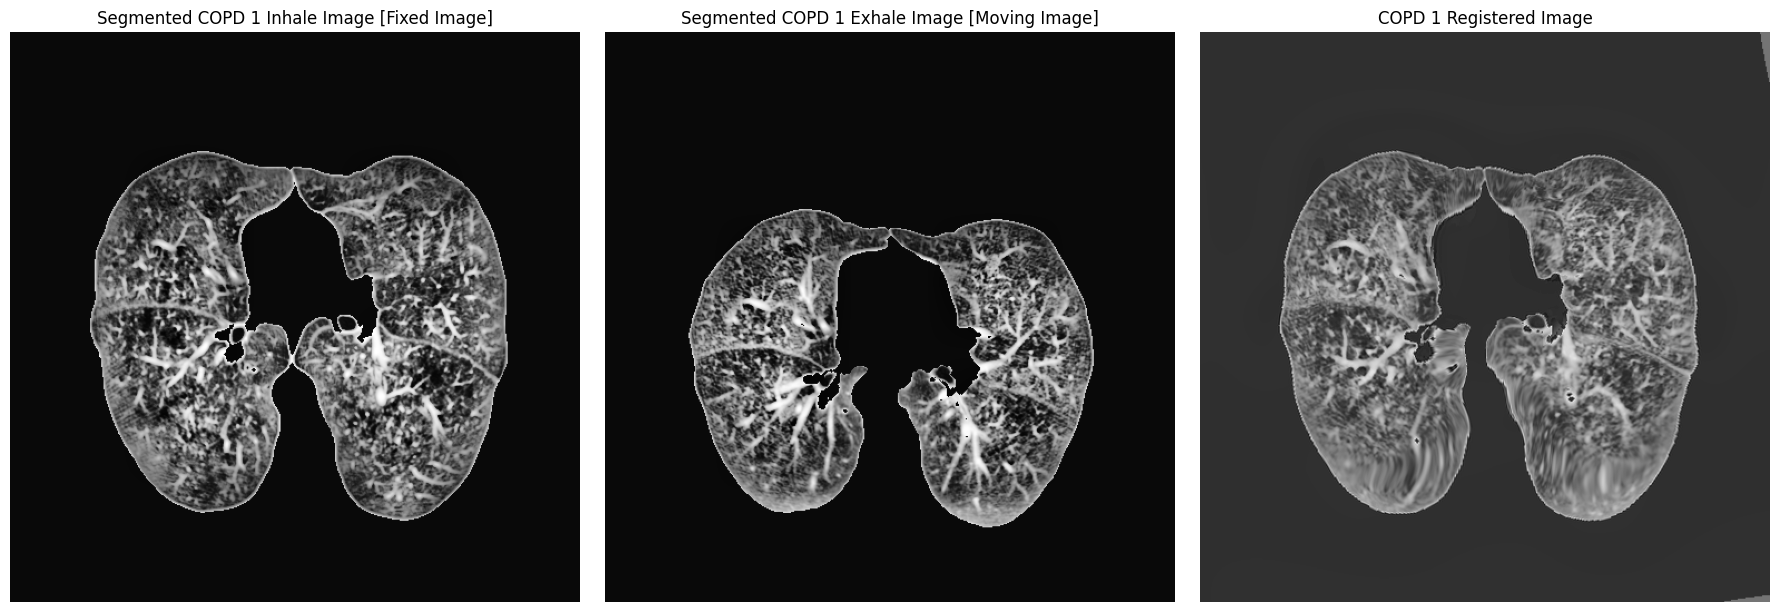

In [15]:
# Load the segmented exhale image
seg_exhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_eBHCT.nii.gz")
img_data_1 = seg_exhale_copd1.get_fdata()

# Load the segmented inhale image
seg_inhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_iBHCT.nii.gz")
img_data_2 = seg_inhale_copd1.get_fdata()

# Load the registered image
registered_image_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/reg_copd1_BHCT.nii.gz"
registered_image = nib.load(registered_image_path)
img_data_registered = registered_image.get_fdata()

# Rotate the images
img_data_1 = np.rot90(img_data_1, k=-1)
img_data_2 = np.rot90(img_data_2, k=-1)
img_data_registered = np.rot90(img_data_registered, k=-1)

# Plotting the images side by side
plt.figure(figsize=(18, 6))
z_slice_1 = img_data_1.shape[2] // 2

# Plot the second image (Inhale)
z_slice_2 = img_data_2.shape[2] // 2
plt.subplot(1, 3, 1)
plt.imshow(img_data_2[:, :, z_slice_2], cmap='gray')
plt.axis('off') 
plt.title('Segmented COPD 1 Inhale Image [Fixed Image]')

# Plot the first image (Exhale)
plt.subplot(1, 3, 2)
plt.imshow(img_data_1[:, :, z_slice_1], cmap='gray')
plt.axis('off')
plt.title('Segmented COPD 1 Exhale Image [Moving Image]')

# Plot the third image
z_slice_registered = img_data_registered.shape[2] // 2
plt.subplot(1, 3, 3)
plt.imshow(img_data_registered[:, :, z_slice_registered], cmap='gray')
plt.axis('off')
plt.title('COPD 1 Registered Image')

plt.tight_layout() 
plt.show()

### Extract the landmark points from the output points file

In [16]:
def extract_landmarks (filepath):

    new_landmarks = np.zeros((300, 3))
    current_landmark_file = open(filepath, "r")
    reg_ex = r'OutputIndexFixed = \[([\d.\s\-]+)\]'

    for i, line in enumerate(current_landmark_file):
        
        match_found = re.search(reg_ex, line, re.M)
        j = match_found.group(1).split()
        j = [round(float(c)) for c in j]
        new_landmarks[i,:] = j
        
    return new_landmarks

list_id = [1, 2, 3, 4]

for val_i in list_id:
    
    id = val_i
    
    output_name = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/copd{}_reg_transformed_points.txt".format(val_i,val_i,val_i)
    data_directory = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/copd{}/".format(val_i, val_i)
    result_directory = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{}/".format(val_i) + "elastix_out"

    # Ouput points after transformation
    output_point_path = result_directory + "/registered_landmarks" + "/outputpoints.txt"
    
    # Extracting only the landmark points and saving it
    transformed_landmarks = extract_landmarks(output_point_path)
    np.savetxt("{}".format(output_name), transformed_landmarks)

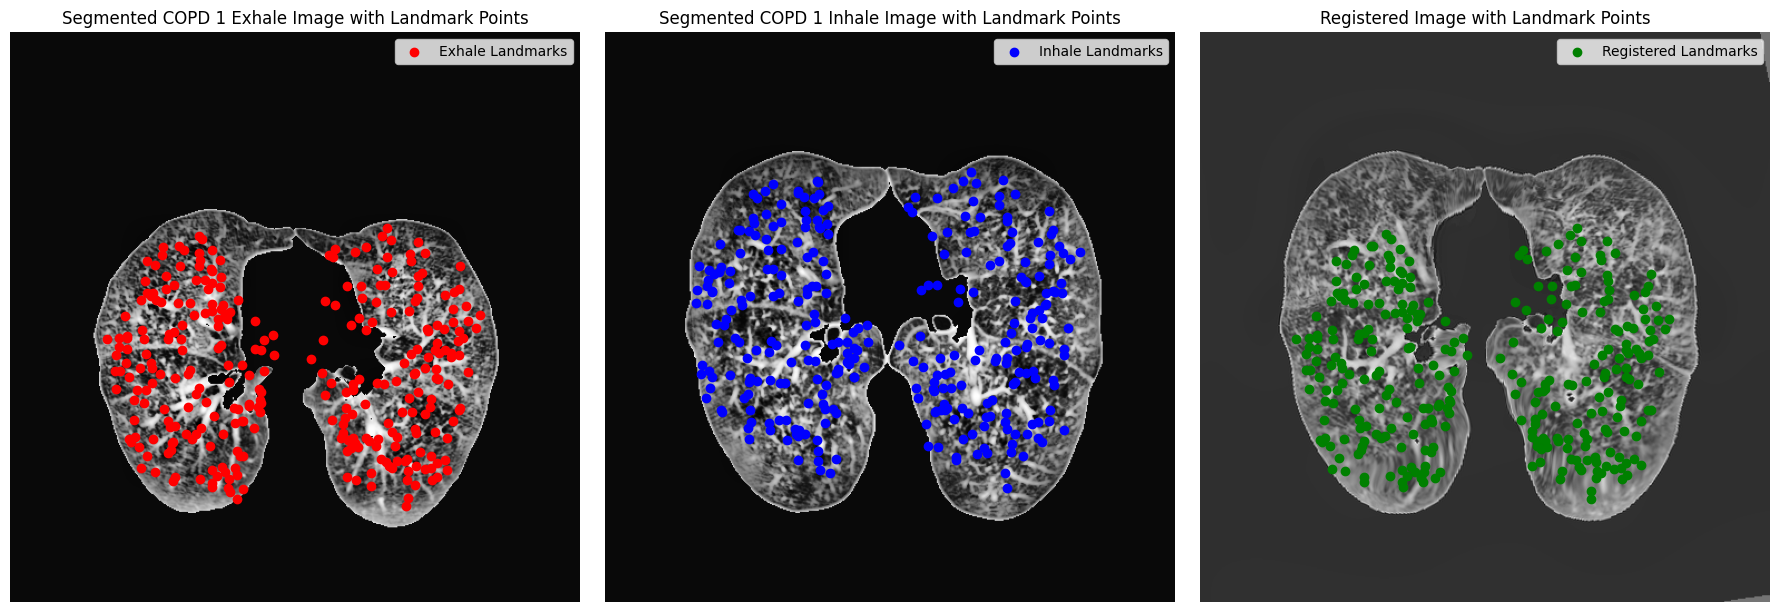

In [17]:
# Function to read landmarks from a file
def read_landmarks(file_path):
    landmarks = np.loadtxt(file_path)
    return landmarks

# Load the exhale and inhale images
seg_exhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_eBHCT.nii.gz")
img_data_1 = seg_exhale_copd1.get_fdata()

seg_inhale_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/seg_copd1_iBHCT.nii.gz")
img_data_2 = seg_inhale_copd1.get_fdata()

# Load the registered image and its landmarks
seg_registered_copd1 = nib.load("D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/reg_copd1_BHCT.nii.gz")
img_data_3 = seg_registered_copd1.get_fdata()

img_data_1_rotated = np.rot90(img_data_1, k=-1)
img_data_2_rotated = np.rot90(img_data_2, k=-1)
img_data_3_rotated = np.rot90(img_data_3, k=-1)

# Load landmark points for exhale and inhale images from text files
landmarks_exhale_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_300_eBH_xyz_r1.txt"  
landmarks_inhale_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_300_iBH_xyz_r1.txt"
landmarks_registered_path = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd1/copd1/copd1_reg_transformed_points.txt"

landmarks_exhale = read_landmarks(landmarks_exhale_path)
landmarks_inhale = read_landmarks(landmarks_inhale_path)
landmarks_registered = read_landmarks(landmarks_registered_path)

# Plotting the images side by side with landmarks
plt.figure(figsize=(18, 6))
z_slice_1 = img_data_1_rotated.shape[2] // 2
z_slice_2 = img_data_2_rotated.shape[2] // 2
z_slice_3 = img_data_3_rotated.shape[2] // 2

# Plot the first image with exhale landmarks
plt.subplot(1, 3, 1)
plt.imshow(img_data_1_rotated[:, :, z_slice_1], cmap='gray')
plt.scatter(landmarks_exhale[:, 0], landmarks_exhale[:, 1], c='red', marker='o', label='Exhale Landmarks')
plt.axis('off')
plt.title('Segmented COPD 1 Exhale Image with Landmark Points')
plt.legend()

# Plot the second image with inhale landmarks
plt.subplot(1, 3, 2)
plt.imshow(img_data_2_rotated[:, :, z_slice_2], cmap='gray')
plt.scatter(landmarks_inhale[:, 0], landmarks_inhale[:, 1], c='blue', marker='o', label='Inhale Landmarks')
plt.axis('off') 
plt.title('Segmented COPD 1 Inhale Image with Landmark Points')
plt.legend()

# Plot the third image with its landmarks
plt.subplot(1, 3, 3)
plt.imshow(img_data_3_rotated[:, :, z_slice_3], cmap='gray')
plt.scatter(landmarks_registered[:, 0], landmarks_registered[:, 1], c='green', marker='o', label='Registered Landmarks')
plt.axis('off')
plt.title('Registered Image with Landmark Points')
plt.legend()

plt.tight_layout() 
plt.show()

### Compute Target Registration Error (TRE)

In [18]:
list_id = [1, 2, 3, 4]
all_mean_tre = []
all_std_tre = []
tre_data = []  # List to store TRE data for each case

for val_i in list_id:
    id = str(val_i)
    data_directory = "D:/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed_v3/copd{0}/copd{0}/".format(id, id)
    inhale_image = data_directory + 'copd' + id + '_iBHCT.nii.gz'
    inhale_points = data_directory + 'copd' + id + '_reg_transformed_points.txt'
    exhale_points = data_directory + 'copd' + id + '_300_eBH_xyz_r1.txt'

    moving_points = np.loadtxt(exhale_points)
    fixed_points = np.loadtxt(inhale_points)

    voxel_spacing = nib.load(inhale_image).header.get_zooms()

    moving_points = voxel_spacing * moving_points
    fixed_points = voxel_spacing * fixed_points

    tre = np.sqrt(np.sum((fixed_points - moving_points) ** 2, axis=1))

    mean_tre = np.mean(tre)
    std_tre = np.std(tre)

    all_mean_tre.append(mean_tre)
    all_std_tre.append(std_tre)
    
    tre_data.append({'Case Name': f'COPD{id}', 'Mean TRE (mm)': mean_tre, 'Std Dev TRE (mm)': std_tre})

# Calculate average mean and standard deviation for all cases
average_mean = np.mean(all_mean_tre)
average_std = np.mean(all_std_tre)

# Format output with 2 decimal places and "mm"
formatted_mean = "{:.2f}".format(average_mean)
formatted_std = "{:.2f}".format(average_std)

# Generate table data
table_data = [[case['Case Name'], "{:.2f}".format(case['Mean TRE (mm)']), "{:.2f}".format(case['Std Dev TRE (mm)'])] for case in tre_data]
table_data.append(['Average', formatted_mean, formatted_std])

# Create and display the table
headers = ["Case Name", "Mean TRE (mm)", "Std Dev TRE (mm)"]
print(tabulate(table_data, headers=headers, tablefmt="pretty"))

+-----------+---------------+------------------+
| Case Name | Mean TRE (mm) | Std Dev TRE (mm) |
+-----------+---------------+------------------+
|   COPD1   |     1.52      |       1.86       |
|   COPD2   |     4.87      |       5.39       |
|   COPD3   |     1.24      |       1.06       |
|   COPD4   |     1.67      |       1.57       |
|  Average  |     2.32      |       2.47       |
+-----------+---------------+------------------+
